In [ ]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# add path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from src.utils import train_and_evaluate

# hide warnings
warnings.filterwarnings("ignore")

### Question: Can the customer churn be predicted based on the features?

1. step 1: Transfer the features into a new DataFrame with unique customer IDs
    - requency, total and average purchase amount by payment method
    - count of purchases by product category, amount spent by product category
2. step 2: Train and evaluate a model to predict customer churn
3. Results
    - It is shown that even though the data can be transformed into customer-level features, the model is not able to predict customer churn well. The AuC is only 0.5 to 0.51, which is no better than random guessing.
    - Why? the features may not be sufficient to predict customer churn effectively.
    - The definition of churn may not be clear or consistent.
    - The dataset may not have enough historical data to capture patterns leading to churn.

In [14]:
df = pd.read_csv("../data/processed/ecommerce_customer_data_cleaned.csv")
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

In [15]:
# Aggregate features at the customer level
customer_features = df.groupby('Customer ID').agg(
    total_purchases=('Total Purchase Amount', 'sum'),
    avg_purchase_amount=('Total Purchase Amount', 'mean'),
    purchase_count=('Total Purchase Amount', 'count'),
    age=('Age', 'first'),
    gender=('Gender', 'first'),
    churn=('Churn', 'first')
)

# Frequency, total, and average purchase amount by payment method
payment_method_stats = df.pivot_table(
    index='Customer ID',
    columns='Payment Method',
    values='Total Purchase Amount',
    aggfunc=['count', 'sum', 'mean'],
    fill_value=0
)
# Flatten MultiIndex columns
payment_method_stats.columns = ['_'.join(col).strip() for col in payment_method_stats.columns.values]

# Count of purchases and amount spent by product category
product_category_stats = df.pivot_table(
    index='Customer ID',
    columns='Product Category',
    values='Total Purchase Amount',
    aggfunc=['count', 'sum'],
    fill_value=0
)
# Flatten MultiIndex columns
product_category_stats.columns = ['_'.join(col).strip() for col in product_category_stats.columns.values]


# Calculate purchase date features
purchase_date_features = df.groupby('Customer ID')['Purchase Date'].agg([
    ('first_purchase_date', 'min'),
    ('last_purchase_date', 'max'),
    ('purchase_count', 'count')
])

In [16]:
# Calculate recency (days since last purchase), frequency (number of purchases), and tenure (days between first and last purchase)
purchase_date_features['recency_days'] = (df['Purchase Date'].max() - purchase_date_features['last_purchase_date']).dt.days
purchase_date_features['tenure_days'] = (purchase_date_features['last_purchase_date'] - purchase_date_features['first_purchase_date']).dt.days
purchase_date_features['avg_days_between_purchases'] = purchase_date_features['tenure_days'] / (purchase_date_features['purchase_count'] - 1)
purchase_date_features['avg_days_between_purchases'] = purchase_date_features['avg_days_between_purchases'].replace([np.inf, -np.inf], np.nan)
purchase_date_features['avg_days_between_purchases'] = purchase_date_features['avg_days_between_purchases'].fillna(purchase_date_features['recency_days'])
purchase_date_features = purchase_date_features[['recency_days', 'tenure_days', 'avg_days_between_purchases']]

# Combine all features into a single DataFrame
customer_df = pd.concat([customer_features, payment_method_stats, product_category_stats, purchase_date_features], axis=1)

# male 1, else 0
customer_df['gender'] = customer_df['gender'].apply(lambda x: 1 if x == 'Male' else 0).astype('int64')
customer_df['churn'] = customer_df['churn'].astype('int64')

# Save the customer-level features to a CSV file
customer_features_path = "../data/processed/ecommerce_customer_features.csv"
customer_df.to_csv(customer_features_path, index=True)
customer_df.head()

,total_purchases,avg_purchase_amount,purchase_count,age,gender,churn,count_Cash,count_Credit Card,count_PayPal,sum_Cash,...,count_Clothing,count_Electronics,count_Home,sum_Books,sum_Clothing,sum_Electronics,sum_Home,recency_days,tenure_days,avg_days_between_purchases
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,6290,2096.666667,3,67,0,0,1,2,0,385,...,1,1,0,5148,385,757,0,288,999,499.500000
2,16481,2746.833333,6,42,0,0,2,1,3,5330,...,1,3,1,4693,679,6383,4726,72,1067,213.400000
3,9423,2355.750000,4,31,1,0,1,2,1,4687,...,1,2,1,0,1394,6857,1172,222,1111,370.333333
4,7826,1565.200000,5,37,1,0,2,1,2,3782,...,1,1,1,4321,2253,823,429,441,624,156.000000
5,9769,1953.800000,5,24,0,0,1,2,2,694,...,0,0,3,6987,0,0,2782,424,828,207.000000


In [17]:
customer_features_path = "../data/processed/ecommerce_customer_features.csv"
customer_df = pd.read_csv(customer_features_path)

In [18]:
X = customer_df.drop(columns=['churn'])
y = customer_df['churn'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# create a dictionary to map model names to the model objects
model_dict = {
    "logistic": LogisticRegression(max_iter=1000),
    "xgboost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "random_forest": RandomForestClassifier(),
    "lightgbm": LGBMClassifier()
}

# train and evaluate models on the customer-level features
results = []
for model_name, model in model_dict.items():
    # Train and evaluate the model
    result_dict = train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name)
    results.append(result_dict)
results_df = pd.DataFrame(results)
print(results_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7950, number of negative: 31778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4219
[LightGBM] [Info] Number of data points in the train set: 39728, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200111 -> initscore=-1.385602
[LightGBM] [Info] Start training from score -1.385602
           model  accuracy  precision    recall  f1_score       auc
0       logistic  0.800765   0.000000  0.000000  0.000000  0.512924
1        xgboost  0.797342   0.257143  0.009096  0.017570  0.506625
2  random_forest  0.800564   0.250000  0.000505  0.001009  0.510146
3       lightgbm  0.800664   0.000000  0.000000  0.000000  0.510875


### Question 4: Can the transaction data be segmented with unsupervised learning methods to identify distinct customer groups?
Though we found the supervised models cannot predict churn and returns well, it is still worth exploring unsupervised learning methods to segment customers based on their transaction data.
### Unsupervised learning methods to segment customers
it seems like not able to segment customers with clear, meaningful, and manipulated way.
- [x] K-Means
- [x] Hierarchical Clustering
- [x] DBSCAN

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# 1. Preprocessing: Scaling (excluding 'churn' and any non-numeric columns)
features_for_clustering = customer_df.drop(columns=['churn'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

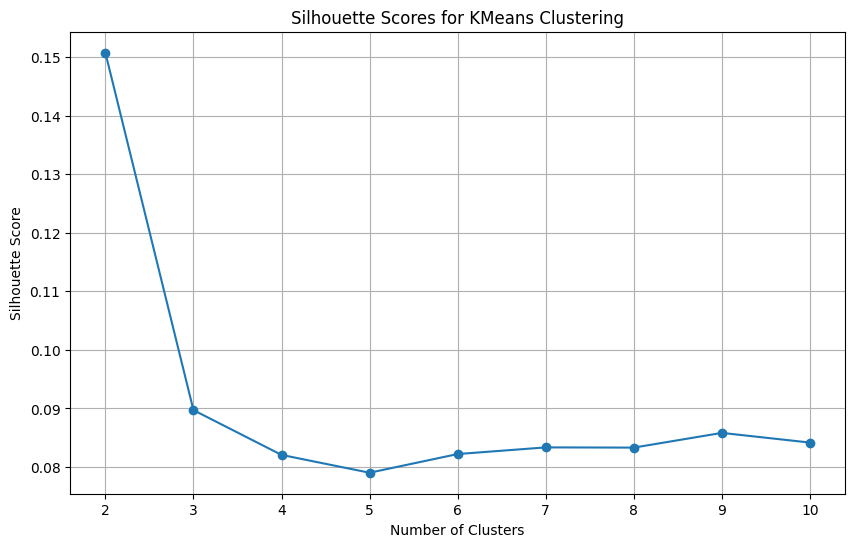

In [ ]:
# find best number of clusters for KMeans
from sklearn.metrics import silhouette_score
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
customer_df['kmeans_cluster'] = kmeans_labels

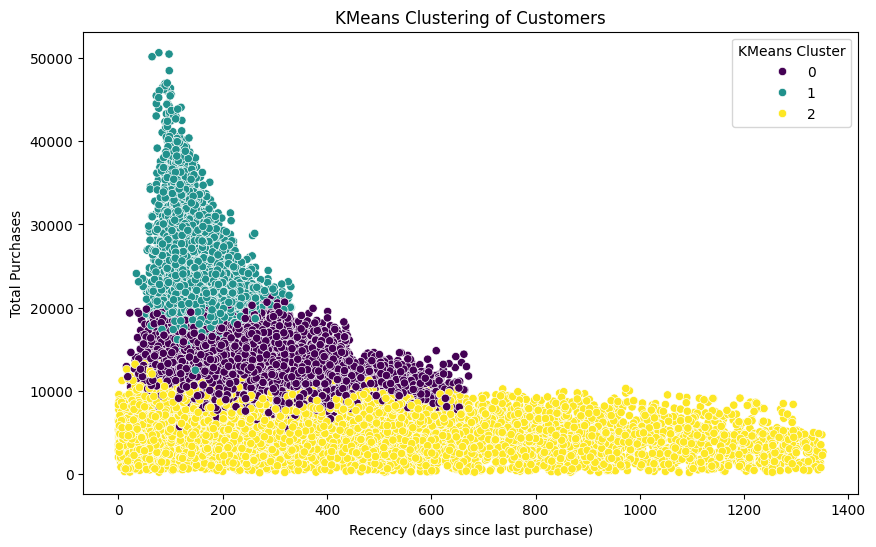

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_df['avg_days_between_purchases'], y=customer_df['total_purchases'], hue=customer_df['kmeans_cluster'], palette='viridis')
plt.title('KMeans Clustering of Customers')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Total Purchases')
plt.legend(title='KMeans Cluster')
plt.show()

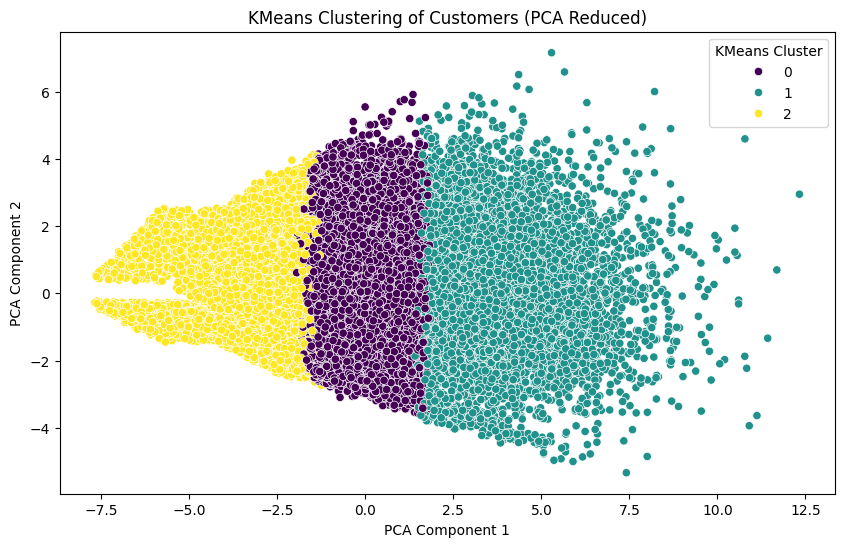

In [ ]:
# what if we use PCA to reduce the dimensionality of the data before clustering?
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_df['kmeans_cluster'], palette='viridis')
plt.title('KMeans Clustering of Customers (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='KMeans Cluster')
plt.show()

In [ ]:
# to see the values in each cluster
customer_df.groupby('kmeans_cluster').mean().T

kmeans_cluster,0,1,2
total_purchases,13246.201013,22663.086217,6233.666047
avg_purchase_amount,2762.206495,2939.536709,2467.573131
purchase_count,4.924457,7.820855,2.634525
age,43.489850,44.785777,43.550219
gender,0.502975,0.501798,0.501747
churn,0.198354,0.202956,0.199911
count_Cash,1.635662,2.578825,0.890714
count_Credit Card,1.629458,2.631562,0.892350
count_PayPal,1.659337,2.610467,0.851461
sum_Cash,4383.090314,7456.354215,2100.234629


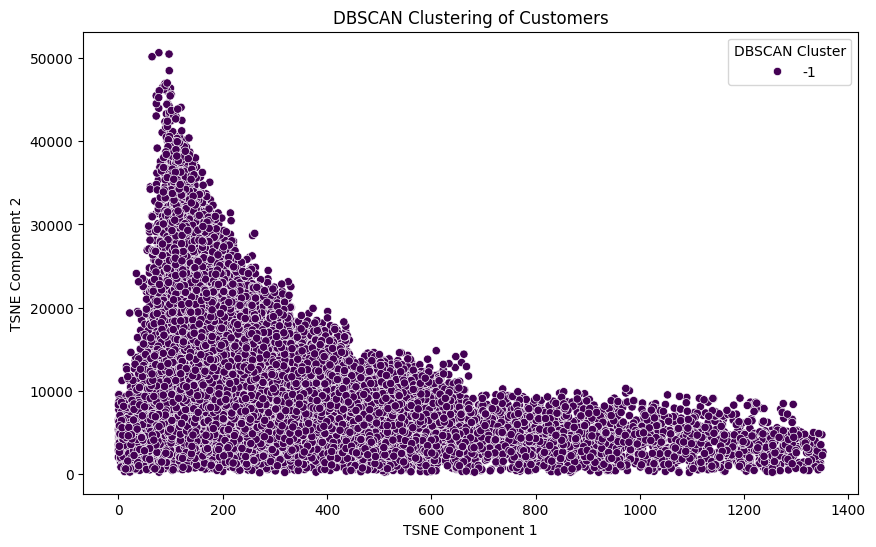

In [ ]:
# 3. DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=500)
dbscan_labels = dbscan.fit_predict(X_scaled)
customer_df['dbscan_cluster'] = dbscan_labels

# Visualize DBSCAN clusters on 2D using TSNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_df['avg_days_between_purchases'], y=customer_df['total_purchases'], hue=customer_df['dbscan_cluster'], palette='viridis')
plt.title('DBSCAN Clustering of Customers')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='DBSCAN Cluster')
plt.show()


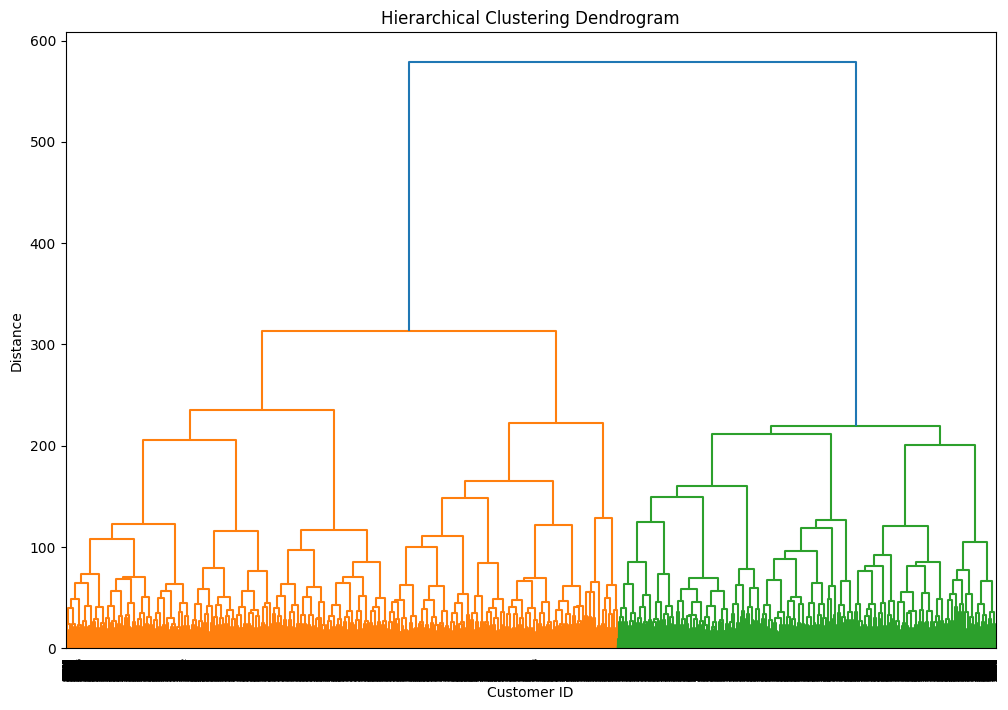

In [ ]:

# 4. Hierarchical clustering (Agglomerative)
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_scaled)
customer_df['hierarchical_cluster'] = agglo_labels

customer_df[['kmeans_cluster', 'dbscan_cluster', 'hierarchical_cluster']].head()
# Visualize Hierarchical clusters with tree diagram
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(12, 8))
linked = linkage(X_scaled, method='ward')
dendrogram(linked, orientation='top', labels=customer_df.index, distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer ID')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Though it shows that the kmeans can be separated through the chart as there is no critical extreme values,
# We concern that the clusters are just different from each other in Recency, Frequency, and Monetary value,
# but demographic features are not considered. Hence, we can try directly use traditional RFM model to segment customers.

In [ ]:
# RFM Segmentation
# Calculate RFM metrics
rfm_df = customer_df[['recency_days', 'avg_days_between_purchases', 'total_purchases']]
rfm_df.rename(columns={
    'recency_days': 'recency_days',
    'avg_days_between_purchases': 'frequency_days',
    'total_purchases': 'monetary_value'
}, inplace=True)

/var/folders/zd/56pqnjt95rd7ng30xkgt3wzw0000gn/T/ipykernel_16907/1203916015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df.rename(columns={


In [ ]:
# RFM scoring
rfm_df['recency_score'] = pd.qcut(rfm_df['recency_days'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm_df['frequency_score'] = pd.qcut(rfm_df['frequency_days'], 4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['monetary_score'] = pd.qcut(rfm_df['monetary_value'], 4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['RFM_Score'] = rfm_df['recency_score'] + rfm_df['frequency_score'] + rfm_df['monetary_score']
# Assign RFM segments based on the RFM score
def rfm_segment(score):
    if score >= 10:
        return 'High Value'
    elif score >= 7:
        return 'Medium Value'
    else:
        return 'Low Value'
rfm_df['RFM_Segment'] = rfm_df['RFM_Score'].apply(rfm_segment)

/var/folders/zd/56pqnjt95rd7ng30xkgt3wzw0000gn/T/ipykernel_16907/239194604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['recency_score'] = pd.qcut(rfm_df['recency_days'], 4, labels=[4, 3, 2, 1]).astype(int)
/var/folders/zd/56pqnjt95rd7ng30xkgt3wzw0000gn/T/ipykernel_16907/239194604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['frequency_score'] = pd.qcut(rfm_df['frequency_days'], 4, labels=[1, 2, 3, 4]).astype(int)
/var/folders/zd/56pqnjt95rd7ng30xkgt3wzw0000gn/T/ipykernel_16907/2

<Axes: xlabel='RFM_Segment'>

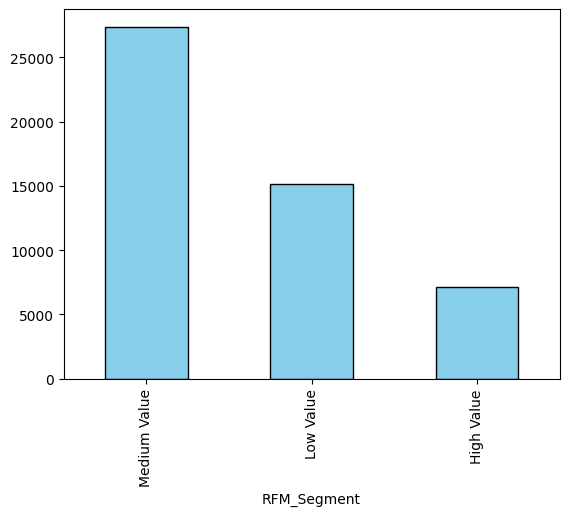

In [ ]:
rfm_df['RFM_Segment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

<Axes: xlabel='avg_days_between_purchases', ylabel='total_purchases'>

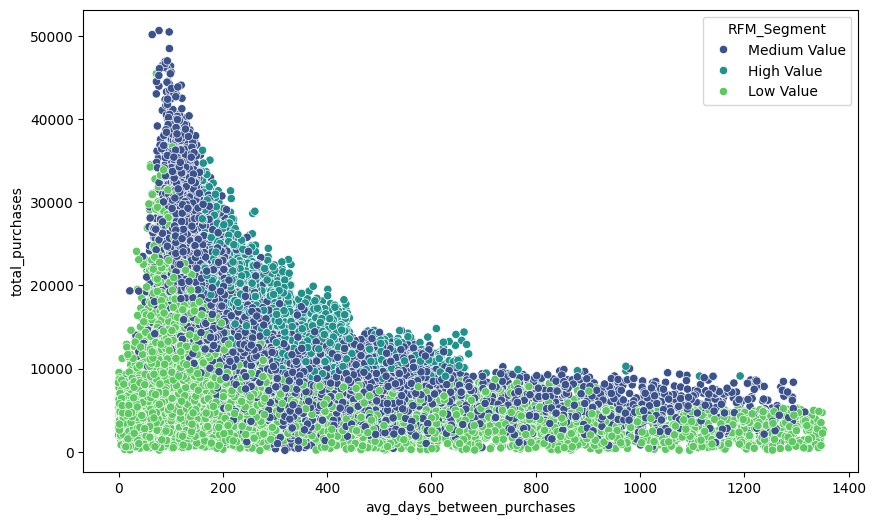

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_df['avg_days_between_purchases'], y=customer_df['total_purchases'], hue=rfm_df['RFM_Segment'], palette='viridis')
